In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from src.data.load_data import prepare_data, plot_spectrogram, plot_distribution
from src.models.anomaly_detectors import ZScoreDetector, AutoencoderDetector

In the context of the DroneRF dataset, a "segment" refers to a single recording of RF data. Each segment represents a continuous period of data collection for capturing a specific drone activity or background RF noise. The dataset splits each segment into two parts: "High" and "Low". "High" refers to the higher frequency components of the signal while "Low" refers to the lower frequency components of the signal. Let's start off by using 5 pairs of segments

## Loading in and preprocessing DroneRF data

Here, we are combining segments into NumPy format and creating spectrograms for each windowed portion. This was we get way more training samples.

In [2]:
base_path = './data/raw/known_signal_subset'
data = prepare_data(base_path, num_segments = 5)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/Users/rdura/repos/signal-fingerprinting/src/data/load_data.py:16: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
100%|█████████████████████████████████████████████| 5/5 [01:05<00:00, 13.04s/it]


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Saving to numpy file
processed_path = './data/processed/spectrogram_data'
np.save(processed_path, data)

In [ ]:
# Used when data preprocessing is already done
# data = np.load('./data/processed/spectrogram_data.npy')

In [3]:
print(f"Number of processed samples: {len(data)}")
print(f"Shape of each spectrogram: {data[0][2].shape}")

Number of processed samples: 49990
Shape of each spectrogram: (512, 2)


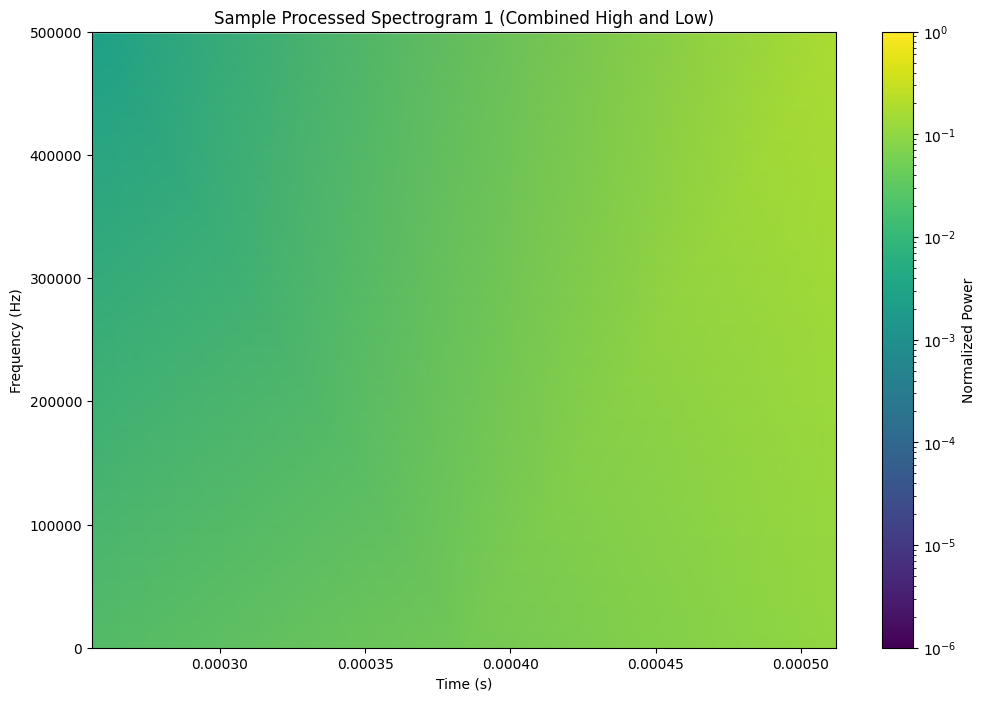

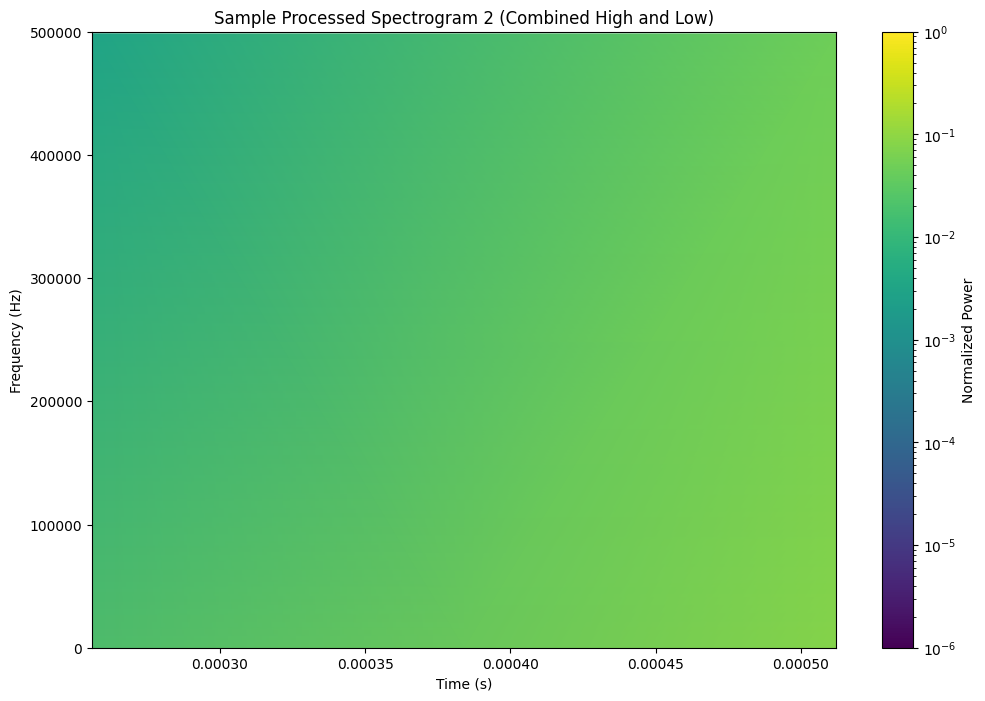

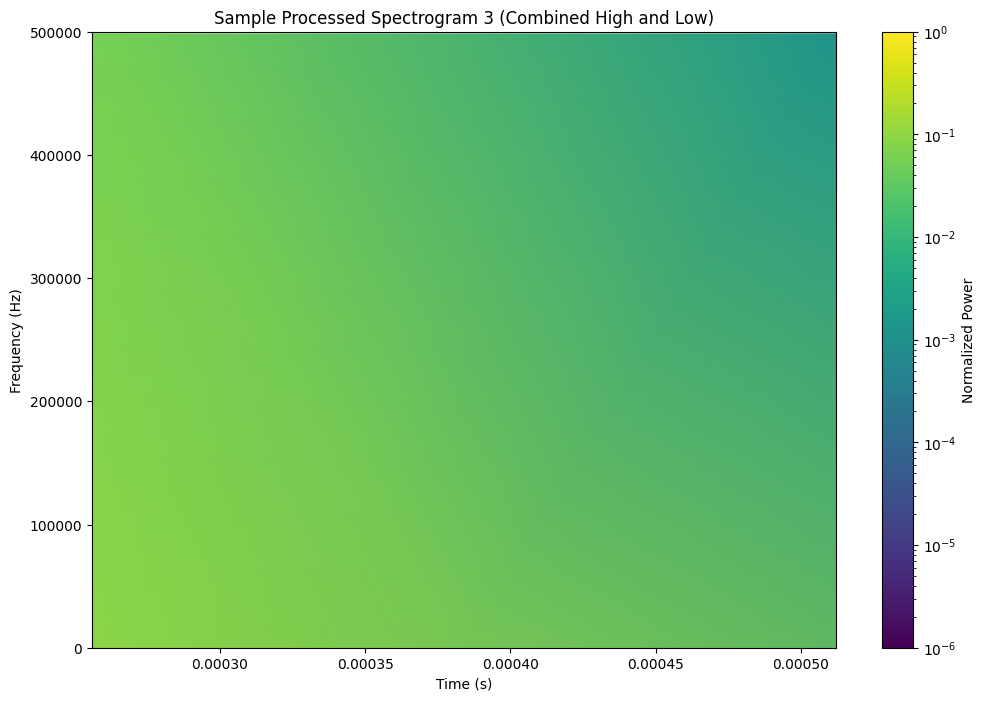

In [4]:
for i in range(3):
    plot_spectrogram(data[i*100], f"Sample Processed Spectrogram {i+1} (Combined High and Low)")

In [7]:
all_values = np.concatenate([spec[2].flatten() for spec in data])
print(f"Min value: {np.min(all_values)}")
print(f"Max value: {np.max(all_values)}")
print(f"Mean value: {np.mean(all_values)}")
print(f"Median value: {np.median(all_values)}")

Min value: 0.0
Max value: 1.0
Mean value: 0.056409645825624466
Median value: 0.03090234100818634


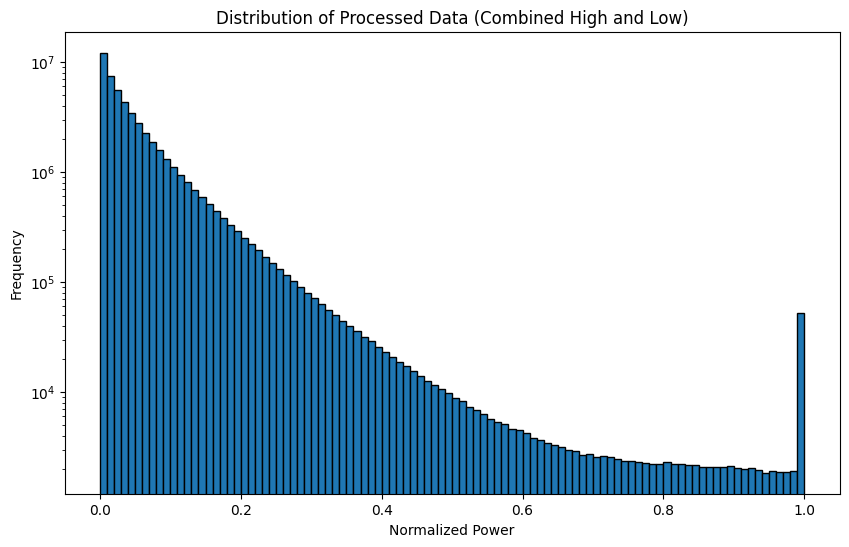

1th percentile: 0.000125
5th percentile: 0.001178
10th percentile: 0.003087
25th percentile: 0.010767
50th percentile: 0.030902
75th percentile: 0.072014
90th percentile: 0.136240
95th percentile: 0.191532
99th percentile: 0.353735


In [14]:
plot_distribution(data, "Distribution of Processed Data (Combined High and Low)")

percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(all_values, p):.6f}")

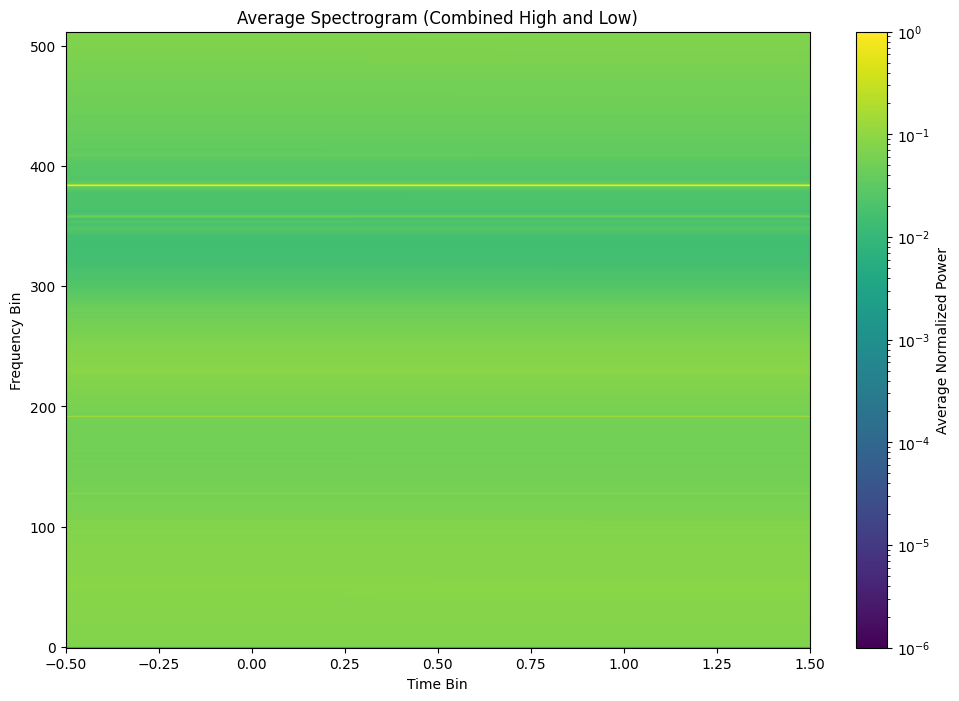

In [10]:
avg_spectrogram = np.mean([spec[2] for spec in data], axis=0)
plt.figure(figsize=(12, 8))
plt.imshow(avg_spectrogram, aspect='auto', origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-6, vmax=1))
plt.title("Average Spectrogram (Combined High and Low)")
plt.xlabel('Time Bin')
plt.ylabel('Frequency Bin')
plt.colorbar(label='Average Normalized Power')
plt.show()

## Training each anomaly detector

In [ ]:
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [ ]:
# Z-Score Detector
z_detector = ZScoreDetector(threshold=3.0)
z_detector.fit(train_data)
z_anomalies = z_detector.predict(test_data)
print(f"Z-Score Detector found {sum(z_anomalies)} anomalies")

In [ ]:
#Autoencoder Detector
input_shape = train_data.shape[1:]  # This should now work with your actual data shape
ae_detector = AutoencoderDetector(input_shape, threshold=0.1)
ae_detector.fit(train_data, epochs=10, batch_size=32)
ae_anomalies = ae_detector.predict(test_data)
print(f"Autoencoder Detector found {sum(ae_anomalies)} anomalies")